In [ ]:
#impot packages
import pandas as pd
from sklearn.utils import resample

In [ ]:
#Import authority from google to use bigquery
from google.colab import auth
auth.authenticate_user()

In [ ]:
#extracting data
%%bigquery df --project abc df
select * 
from abc)

In [ ]:
#Data exibition
display(df.shape,df.head())

(30848, 55)

,_id,city_code,home_zone,source,model_number,AGE,smartphone_brand,smartphone_model,license_type,city,driver_id,Start,Last_date,Trips,Recency,frequency,avg_h,working_perc,non_sawari,freq_work_days,monetory,FF,low_rated,avg_rating,ratings_given,promo_rides,wallet_rides,fake_dist,pickup_avg,physical_loc,zero_km,avg_trip_dist,avg_trip_time,avg_trip_speed,users,dd,net_busy,fake_imei,Low_rating_perc,ratings_perc,promo_rides_perc,wallet_rides_perc,physical_loc_perc,fake_dist_perc,zero_km_perc,fake_imei_perc,repeat_users_perc,defaulter,bonus,avg_bonus,total_bonus,limit_reached,activehours_delta,ff_delta,accp_delta
0,5abcff3ebd850b62774cf82c,KHI,None,Franchise,2017,25.0,Motorolla,Drioad HD,Learner,58f9d76315f7617c3705db21,5abcff3ebd850b62774cf82c,2018-03-30,2018-05-15,144,1055,21.913043,14.853571,0.630435,0.104167,34.758621,17024,0.514286,10,4.741259,143,4,25,33,8.902778,47,1,9.875000,25.944444,25.091163,128,0.000000,3.150000,0,0.069930,0.993056,0.027778,0.173611,0.326389,0.229167,0.006944,0.000000,0.888889,0,0.750000,281.818182,3100.0,0.066667,-1.812952,NaN,1.320619
1,5af1d7d2554d9f31efed088b,KHI,Malir & Airport,Organic,2011,38.0,Samsung,S7,Permanent,58f9d76315f7617c3705db21,5af1d7d2554d9f31efed088b,2018-05-09,2020-05-28,410,312,3.826667,8.934247,0.250667,0.102439,19.930556,50965,0.561644,24,4.787958,382,29,74,72,8.699267,36,7,11.436585,22.767726,31.370566,378,0.034146,2.000000,19,0.062827,0.931707,0.070732,0.180488,0.087805,0.175610,0.017073,0.046341,0.921951,0,0.681818,220.714286,15450.0,0.020202,-0.831833,14.554667,0.222667
2,5e44162c10dbd821cf787e35,KHI,FB Area,Franchise,2018,29.0,Oppo,F7,Learner,58f9d76315f7617c3705db21,5e44162c10dbd821cf787e35,2020-02-14,2020-12-14,224,111,5.157895,17.264407,0.263158,0.084821,20.363636,25040,0.759322,5,4.903846,208,4,18,59,7.004464,29,2,9.357466,21.875000,27.496399,205,0.227679,2.283333,11,0.024038,0.928571,0.017857,0.080357,0.129464,0.263393,0.008929,0.049107,0.915179,0,0.000000,NaN,NaN,0.010753,-2.583056,4.461333,5.674667
3,5b17bffc4b1f9c652324ab9c,KHI,Gulistan-e-Johar,Partner Referral,2015,51.0,Samsung,SM-J120A,Permanent,58f9d76315f7617c3705db21,5b17bffc4b1f9c652324ab9c,2018-06-10,2021-03-09,740,17,5.164506,12.674901,0.459621,0.037838,14.309392,87685,0.326423,53,4.710490,715,44,62,119,9.829499,166,20,11.596491,24.440379,30.103593,645,0.108108,0.300000,76,0.074126,0.966216,0.059459,0.083784,0.224324,0.160811,0.027027,0.102703,0.871622,0,0.660377,1.836957,169.0,0.268018,0.523574,3.587333,8.916000
4,5e32e490fe3b161ee7b72772,KHI,Garden,Franchise,2019,42.0,Samsung,J4,Learner,58f9d76315f7617c3705db21,5e32e490fe3b161ee7b72772,2020-01-31,2021-03-09,339,26,5.888337,14.184109,0.243176,0.008850,25.793478,23351,0.656977,8,4.873817,317,11,22,137,4.914201,76,0,8.655022,18.094395,31.900930,326,0.032448,1.400000,28,0.025237,0.935103,0.032448,0.064897,0.224189,0.404130,0.000000,0.082596,0.961652,0,0.000000,NaN,NaN,0.010638,-0.561963,-0.769333,-0.928667


In [ ]:
#adjusting datetime
df.Last_date = pd.to_datetime(df.Last_date)
df[df.Last_date < '2020-03-01'].defaulter.count()
df = df[df.Last_date <= '2020-03-01']

13384

In [ ]:
#creating copy of df for reuse
df_original = df # this is a one time run cell 

In [ ]:
df =df_original
df.groupby('defaulter').defaulter.count()

defaulter
0    8689
1    4730
Name: defaulter, dtype: int64

In [ ]:
#shape of data
display(df.shape, df.isnull().sum())

(13419, 55)

_id                     0
city_code               0
home_zone             390
source                554
model_number            0
AGE                    29
smartphone_brand       12
smartphone_model        4
license_type            8
city                    0
driver_id               0
Start                   0
Last_date               0
Trips                   0
Recency                 0
frequency               0
avg_h                   0
working_perc            0
non_sawari              0
freq_work_days          0
monetory                0
FF                      0
low_rated               0
avg_rating              9
ratings_given           0
promo_rides             0
wallet_rides            0
fake_dist               0
pickup_avg              0
physical_loc            0
zero_km                 0
avg_trip_dist           0
avg_trip_time           0
avg_trip_speed         93
users                   0
dd                      0
net_busy                0
fake_imei               0
Low_rating_p

In [ ]:
# Data Tunning
df.drop(['source','home_zone'],axis = 1,inplace = True)
df[['avg_bonus','total_bonus']].fillna(0,inplace=True)
df.fillna(df.mean(),inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set 

In [ ]:

# Separate majority and minority classes

# df = df_full
df_majority = df[df.defaulter==0]
df_minority = df[df.defaulter==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=4783,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
display(df.defaulter.value_counts(), df_downsampled.defaulter.value_counts())

0    8858
1    4804
Name: defaulter, dtype: int64

1    4804
0    4783
Name: defaulter, dtype: int64

In [ ]:
#Creating another copy
df_full = df
df = df_downsampled

In [ ]:
#Factoring Age of the driver and creating X and Y
X = df[df.AGE >= 18]
y = df[df.AGE >= 18].loc[:, 'defaulter']

In [ ]:
X['KHI'] = 0
X.loc[X['city_code'] == 'KHI', 'KHI'] = 1
X['RWP'] = 0
X.loc[X['city_code'] == 'RWP', 'RWP'] = 1
X['LHR'] = 0
X.loc[X['city_code'] == 'LHR', 'LHR'] = 1

In [ ]:
X.describe()

,AGE,Trips,Recency,frequency,avg_h,working_perc,non_sawari,freq_work_days,monetory,FF,low_rated,avg_rating,ratings_given,promo_rides,wallet_rides,fake_dist,pickup_avg,physical_loc,zero_km,avg_trip_dist,avg_trip_time,avg_trip_speed,users,dd,net_busy,fake_imei,Low_rating_perc,ratings_perc,promo_rides_perc,wallet_rides_perc,physical_loc_perc,fake_dist_perc,zero_km_perc,fake_imei_perc,repeat_users_perc,defaulter,bonus,avg_bonus,total_bonus,limit_reached,net_util
count,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000
mean,31.349863,283.842000,284.506926,14.162917,14.540297,0.506753,0.137276,25.775680,33344.843271,0.535012,20.225858,4.717436,270.907850,31.141471,60.098307,101.502978,7.082677,35.718463,5.801646,10.311803,23.573381,28.856116,255.424078,0.039886,1.984493,23.869370,0.074312,0.952578,0.113589,0.206203,0.129377,0.322397,0.022522,0.090476,0.919027,0.337482,0.732804,237.970261,6400.565148,0.244212,0.077467
std,8.952031,312.668199,160.081486,16.105310,2.030703,0.243034,0.119177,17.202389,37711.997204,0.143466,25.810138,0.128774,299.958184,45.345910,90.456592,163.900943,2.201972,48.978760,21.428774,38.114678,5.719348,103.297372,266.255583,0.106656,1.479535,36.895787,0.037007,0.050519,0.108787,0.084640,0.111664,0.166962,0.043340,0.108538,0.097415,0.472867,0.136020,391.395917,12133.782926,0.268437,0.063726
min,-8.000000,1.000000,95.000000,0.040346,3.309783,0.013986,0.000000,1.166667,127.000000,0.057143,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.235294,0.001976,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.034602,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000452,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,123.000000,150.000000,5.473066,13.207449,0.310733,0.050000,16.722222,13985.500000,0.439065,8.000000,4.657736,117.000000,7.000000,23.000000,31.000000,5.681505,2.000000,1.000000,8.741018,20.792266,25.010001,113.000000,0.000000,1.016667,7.000000,0.051724,0.940594,0.039024,0.160000,0.011494,0.212500,0.004831,0.043478,0.903473,0.000000,0.666667,41.968661,1050.000000,0.018519,0.035223
50%,30.000000,182.000000,247.000000,10.566038,14.584314,0.497630,0.118971,23.115108,20665.000000,0.543233,13.000000,4.733533,173.000000,16.000000,37.000000,55.000000,6.844595,23.000000,3.000000,9.758687,23.330097,27.019825,166.000000,0.007673,1.800000,14.000000,0.069767,0.961749,0.070707,0.200000,0.125000,0.300000,0.012121,0.069444,0.945312,0.000000,0.750000,120.636364,2786.000000,0.134328,0.064818
75%,36.000000,316.000000,379.000000,18.699138,15.918231,0.692308,0.194653,31.365385,36742.000000,0.636797,23.000000,4.795455,302.000000,37.000000,67.000000,109.000000,8.233263,47.000000,6.000000,10.724753,25.952978,29.092833,288.000000,0.033088,2.700000,26.000000,0.091603,0.976630,0.163986,0.238056,0.215190,0.401786,0.025862,0.103053,0.970588,1.000000,0.823529,271.428571,6627.000000,0.417391,0.103216
max,69.000000,5603.000000,772.000000,700.000000,20.907923,2.000000,1.000000,525.000000,896705.000000,1.000000,605.000000,5.000000,5401.000000,840.000000,3696.000000,4592.000000,37.000000,661.000000,918.000000,4071.000000,267.818182,8599.978429,5065.000000,1.000000,55.783333,989.000000,1.000000,1.250000,1.000000,1.000000,1.000000,3.565041,0.919831,2.978495,1.000000,1.000000,1.000000,5733.333333,394602.000000,1.000000,0.946727


In [ ]:
#Furture Dropping
df2 = df.drop(['city_code','net_busy','limit_reached','_id','driver_id', 'model_number','smartphone_brand','smartphone_model','city','Recency', 'promo_rides','ratings_given','low_rated','license_type','Last_date','Start', 'fake_dist',	'physical_loc',	'zero_km',	'fake_imei','users','wallet_rides'	],axis = 1)
import scipy.stats as stats
import numpy as np
z_scores = stats.zscore(df2)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

In [ ]:
#Excluding predicor variable from training dataset
X = df2.drop('defaulter', axis = 1 )
y = df2.loc[:, 'defaulter']

In [ ]:
#Splitting data into train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
X_train.describe()

,AGE,Trips,frequency,avg_h,working_perc,non_sawari,freq_work_days,monetory,FF,avg_rating,pickup_avg,avg_trip_dist,avg_trip_time,avg_trip_speed,dd,Low_rating_perc,ratings_perc,promo_rides_perc,wallet_rides_perc,physical_loc_perc,fake_dist_perc,zero_km_perc,fake_imei_perc,repeat_users_perc,bonus,avg_bonus,total_bonus,activehours_delta,ff_delta,accp_delta
count,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000
mean,32.334637,279.840636,16.358650,14.588513,0.543553,0.147524,30.624778,32693.978981,0.536887,4.714604,7.073671,10.628275,23.500761,29.681311,0.035915,0.075188,0.948471,0.107522,0.204748,0.131016,0.328079,0.027013,0.094971,0.916226,0.724220,250.549514,6366.638715,-0.582664,0.586082,-0.405104
std,9.072396,316.102516,26.277565,2.008585,0.318347,0.143194,26.226549,37710.706658,0.149661,0.143914,2.358961,50.128692,5.481635,129.422722,0.099736,0.040165,0.088904,0.107940,0.089860,0.114998,0.184738,0.064559,0.116060,0.102860,0.151796,411.939577,11903.105219,1.716560,9.802714,10.589045
min,-7.000000,1.000000,0.145833,4.817490,0.033528,0.000000,7.000000,50.000000,0.057143,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000452,0.000000,0.000000,0.000000,-10.018852,-65.521333,-53.122000
25%,27.000000,121.000000,6.152370,13.303552,0.340684,0.053846,20.250000,13763.500000,0.436737,4.655570,5.655404,8.698669,20.816625,24.921362,0.000000,0.051852,0.943662,0.036866,0.157635,0.009174,0.210209,0.004831,0.042709,0.901230,0.666667,40.703676,920.500000,-1.518389,-4.917667,-6.348333
50%,31.000000,176.000000,11.676289,14.610942,0.534591,0.124535,26.551724,20085.000000,0.543524,4.731132,6.861635,9.747826,23.428571,26.940066,0.006303,0.070352,0.964286,0.064706,0.197917,0.125000,0.299107,0.012308,0.074468,0.944099,0.750000,123.076923,2750.000000,-0.577704,0.604528,-0.366022
75%,37.000000,309.500000,20.451029,15.942731,0.728814,0.200000,35.000000,35760.000000,0.639007,4.795699,8.302998,10.737878,26.060880,29.041035,0.029130,0.092391,0.978272,0.150538,0.237050,0.220339,0.406622,0.026712,0.112069,0.969941,0.818182,283.515064,6503.000000,0.371815,5.814738,5.466667
max,70.000000,5274.000000,1421.000000,20.907923,19.000000,1.000000,710.500000,896705.000000,1.000000,5.000000,37.000000,4071.000000,113.234043,8599.978429,1.000000,1.000000,1.333333,1.000000,1.000000,0.827839,3.302158,1.000000,3.014337,1.000000,1.000000,5733.333333,249200.000000,12.738889,54.775333,60.614000


In [ ]:
#Replacing Null with median
X_test.fillna(X_test.median(), inplace = True)
X_train.fillna(X_train.median(), inplace = True)
#check for nulls
X_test.isnull().sum()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


AGE                  0
Trips                0
frequency            0
avg_h                0
working_perc         0
non_sawari           0
freq_work_days       0
monetory             0
FF                   0
avg_rating           0
pickup_avg           0
avg_trip_dist        0
avg_trip_time        0
avg_trip_speed       0
dd                   0
Low_rating_perc      0
ratings_perc         0
promo_rides_perc     0
wallet_rides_perc    0
physical_loc_perc    0
fake_dist_perc       0
zero_km_perc         0
fake_imei_perc       0
repeat_users_perc    0
bonus                0
avg_bonus            0
total_bonus          0
activehours_delta    0
ff_delta             0
accp_delta           0
dtype: int64

In [ ]:
#Model Traing Trial 1
# Create the model with 500 trees
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

sel = SelectFromModel(RandomForestClassifier(n_estimators=500, 
                               bootstrap = True,
                               max_features = 'auto',
                               class_weight="balanced",
                               n_jobs=-1, verbose = 1))
sel.fit(X_train, y_train)
selected_feat= X_train.columns[(sel.get_support())]
display(len(selected_feat), selected_feat)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.3s finished


10

Index(['non_sawari', 'freq_work_days', 'FF', 'avg_trip_time', 'ratings_perc',
       'promo_rides_perc', 'physical_loc_perc', 'bonus', 'avg_bonus',
       'total_bonus'],
      dtype='object')

In [ ]:
selected_feat = ['non_sawari', 'freq_work_days', 'FF', 'avg_trip_time', 'ratings_perc',
       'promo_rides_perc', 'physical_loc_perc', 'bonus', 'avg_bonus',
       'total_bonus']


X_train = X_train[selected_feat]

X_test = X_test[selected_feat]



In [ ]:
#Model Traing Trial 2
# Create the model with 1000 trees
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000, 
                               bootstrap = True,
                               max_features = 'auto',
                               class_weight="balanced",
                               n_jobs=-1, verbose = 1)
# Fit on training data
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [ ]:
rf_predictions = model.predict(X_test)
# Probabilities for each class
rf_probs = model.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


In [ ]:
#Checking Performance Using Different Metrics
from sklearn.metrics import roc_auc_score
# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

0.8219101077992077

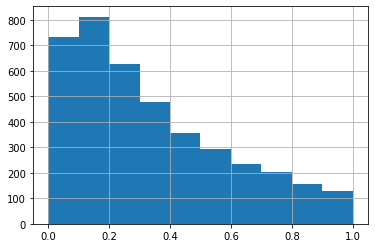

In [ ]:
import numpy as np
pd.Series(rf_probs).hist()

Text(0.5, 1.0, 'predictor Precision-Recall curve: Score =0.73')

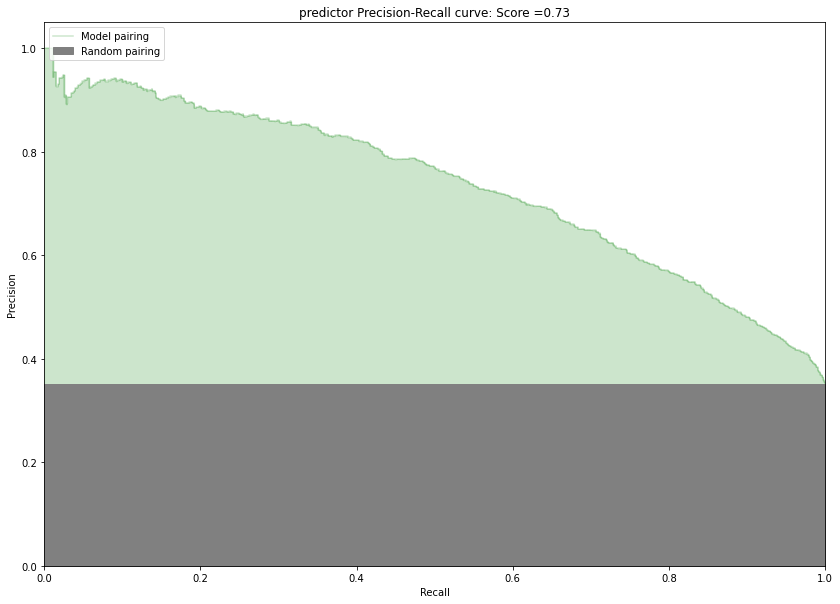

In [ ]:

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature
from sklearn.metrics import average_precision_score

y_pred = rf_probs
average_precision = average_precision_score(y_test, y_pred)
# average_precision - y_test.mean()
precision, recall, _ = precision_recall_curve(y_test,y_pred)
plt.figure(figsize=(14,10))
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='g', alpha=0.2, Label='Model pairing',
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='g', **step_kwargs)
# plt.step([0,1],[0,y_test.mean()],color='green', label= 'RANDOM = %.2f'%0.5,  alpha=1)
plt.fill_between([0,1],[y_test.mean(),y_test.mean()],color='grey', label= 'RANDOM = %.2f'%0.5,  alpha=1, Label='Random pairing')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="upper left")
# plt.title('Rank wise Pickup Distance')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('predictor Precision-Recall curve: Score ={0:0.2f}'.format((average_precision)))

In [ ]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head(25)

,feature,importance
2,FF,0.132882
5,promo_rides_perc,0.132647
6,physical_loc_perc,0.110760
8,avg_bonus,0.107549
0,non_sawari,0.092973
4,ratings_perc,0.090020
1,freq_work_days,0.086945
3,avg_trip_time,0.084877
7,bonus,0.081075
9,total_bonus,0.080271


In [ ]:
#Training Using Logistic Regression 
#Model Traing Trial 3
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

model_logit = sm.Logit(y_train, X_train)
result = model_logit.fit()

result_summary = result.summary()

results_as_html = result_summary.tables[1].as_html()

res = pd.read_html(results_as_html, header=0, index_col=0)[0]
d = X_train
d['intercept'] = 1.0
res['impact'] = d.mean() * res.coef
res.sort_values('impact', ascending = True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.537059
         Iterations 6


,coef,std err,z,P>|z|,[0.025,0.975],impact
FF,-4.198200,0.190000,-22.113,0.000,-4.570000,-3.826000e+00,-2.246679
promo_rides_perc,-3.898400,0.362000,-10.769,0.000,-4.608000,-3.189000e+00,-0.417055
physical_loc_perc,-3.047000,0.265000,-11.501,0.000,-3.566000,-2.528000e+00,-0.396110
avg_bonus,-0.000600,0.000000,-4.952,0.000,-0.001000,-0.000000e+00,-0.147833
freq_work_days,-0.001800,0.002000,-1.198,0.231,-0.005000,1.000000e-03,-0.055410
total_bonus,-0.000007,0.000003,-2.205,0.027,-0.000014,-8.130000e-07,-0.045473
non_sawari,1.531300,0.217000,7.067,0.000,1.107000,1.956000e+00,0.225504
bonus,0.693600,0.195000,3.556,0.000,0.311000,1.076000e+00,0.501888
avg_trip_time,0.024600,0.005000,4.758,0.000,0.014000,3.500000e-02,0.579281
ratings_perc,1.260300,0.216000,5.832,0.000,0.837000,1.684000e+00,1.194779


In [ ]:
col = res[(res['P>|z|'] < 0.05)].T.columns.to_list()
col

['frequency',
 'avg_h',
 'non_sawari',
 'freq_work_days',
 'FF',
 'avg_trip_time',
 'ratings_perc',
 'promo_rides_perc',
 'wallet_rides_perc',
 'physical_loc_perc',
 'fake_dist_perc',
 'repeat_users_perc',
 'bonus',
 'avg_bonus',
 'total_bonus',
 'activehours_delta',
 'ff_delta',
 'accp_delta']

In [ ]:
!pip install shap

     |████████████████████████████████| 276kB 2.9MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394123 sha256=0377def3cbb11f2aa9108560c2a6509cd8206fed83793c3aabdf3c2025430426
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [ ]:

import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# Calculate Shap values
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)

In [ ]:
shap_values[1]

array([[ 7.45357004e-04, -3.41486059e-02,  1.08946660e-02, ...,
         5.34246826e-02,  6.64876485e-02, -5.22380424e-03],
       [ 7.06505060e-03,  9.56464917e-04,  4.21162150e-03, ...,
        -8.37087788e-02, -5.17750349e-02, -1.03847858e-02],
       [ 4.33825294e-03, -1.54207864e-02, -1.07859027e-03, ...,
        -2.17859158e-02, -1.28315573e-02, -3.05259478e-03],
       ...,
       [-4.38321872e-03, -1.47562601e-02, -1.53580041e-03, ...,
         8.13868391e-02,  6.47081982e-02, -7.83068783e-03],
       [ 3.32097589e-03, -1.48951556e-02, -7.61551938e-02, ...,
         6.96284541e-02,  5.87343799e-03, -8.51870632e-05],
       [ 1.76981816e-03, -2.90270760e-02, -8.17839835e-03, ...,
        -4.89253927e-02, -1.74595624e-02,  9.00033766e-03]])

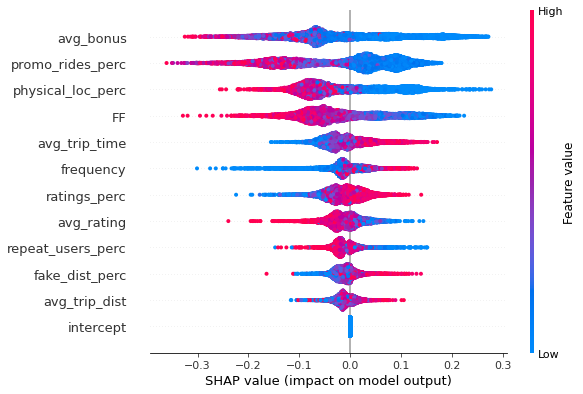

In [ ]:
shap.summary_plot(shap_values[1], X_train)

In [ ]:
y_pred = result.predict(X_test)

In [ ]:
X_test.head()

,AGE,Trips,frequency,avg_h,working_perc,non_sawari,freq_work_days,monetory,FF,avg_rating,pickup_avg,avg_trip_dist,avg_trip_time,avg_trip_speed,dd,Low_rating_perc,ratings_perc,promo_rides_perc,wallet_rides_perc,physical_loc_perc,fake_dist_perc,zero_km_perc,fake_imei_perc,repeat_users_perc,bonus,avg_bonus,total_bonus,activehours_delta,ff_delta,accp_delta
436,33.0,284,11.106145,13.959545,0.553073,0.232394,24.850000,34820,0.359039,4.546099,6.826855,10.528169,24.847518,27.572693,0.000000,0.127660,0.992958,0.077465,0.246479,0.204225,0.429577,0.007042,0.066901,0.915493,0.666667,96.000000,4800.0,4.233333,1.724667,-6.142667
20639,24.0,474,8.618182,15.628906,0.249351,0.215190,38.137931,55969,0.617188,4.756579,5.789030,9.411392,23.852321,25.567577,0.004219,0.059211,0.962025,0.052743,0.213080,0.054852,0.413502,0.006329,0.029536,0.934599,0.833333,239.024390,9800.0,-3.590000,-14.706667,-12.539333
29194,32.0,119,3.590517,13.141487,0.435345,0.008403,10.679487,17430,0.285372,4.820513,7.882353,13.126050,31.245763,26.161243,0.478992,0.042735,0.983193,0.126050,0.151261,0.176471,0.159664,0.016807,0.092437,0.924370,0.806452,22.727273,1000.0,-2.056944,12.777333,-3.530667
1865,-7.0,99,8.451220,15.689815,0.463415,0.111111,22.354839,10412,0.458333,4.556701,7.222222,9.030303,24.202020,23.777535,0.000000,0.134021,0.979798,0.030303,0.171717,0.000000,0.303030,0.030303,0.191919,0.959596,0.636364,244.444444,2200.0,2.796667,-7.634667,2.291333
19230,35.0,90,4.064516,16.531250,0.303226,0.122222,15.750000,10362,0.468750,4.797753,5.788889,9.488889,21.288889,27.405583,0.088889,0.067416,0.988889,0.022222,0.211111,0.000000,0.366667,0.022222,0.066667,0.977778,0.916667,19.260870,443.0,-0.443333,1.388667,-11.526667


In [ ]:
roc_value = roc_auc_score(y_test, y_pred)
roc_value

0.7918246516356677

Text(0.5, 1.0, 'predictor Precision-Recall curve: Score =0.66')

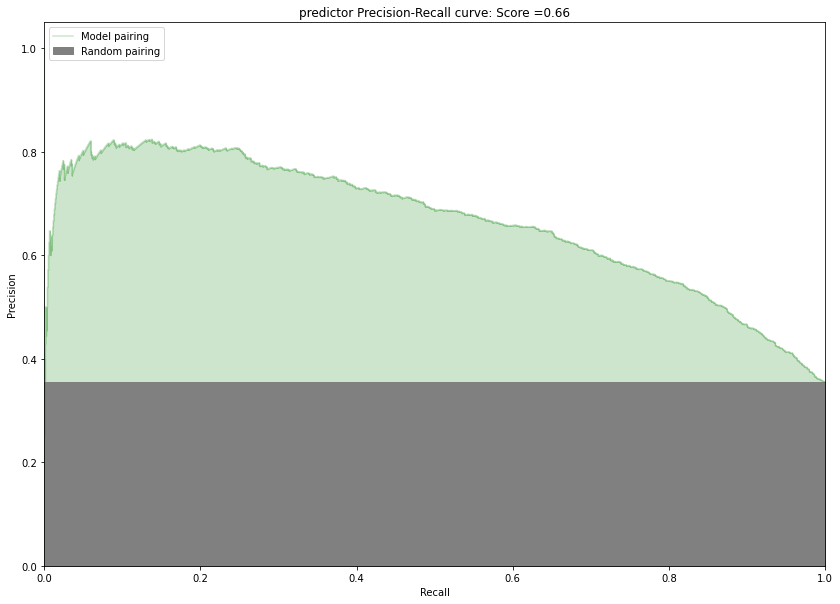

In [ ]:
# y_pred = rf_probs
average_precision = average_precision_score(y_test, y_pred)

# average_precision - y_test.mean()

precision, recall, _ = precision_recall_curve(y_test,y_pred)


plt.figure(figsize=(14,10))


# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='g', alpha=0.2, Label='Model pairing',
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='g', **step_kwargs)

# plt.step([0,1],[0,y_test.mean()],color='green', label= 'RANDOM = %.2f'%0.5,  alpha=1)
plt.fill_between([0,1],[y_test.mean(),y_test.mean()],color='grey', label= 'RANDOM = %.2f'%0.5,  alpha=1, Label='Random pairing')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="upper left")
# plt.title('Rank wise Pickup Distance')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('predictor Precision-Recall curve: Score ={0:0.2f}'.format((average_precision)))

In [ ]:
X_train.columns

Index(['non_sawari', 'freq_work_days', 'FF', 'avg_trip_time', 'ratings_perc',
       'promo_rides_perc', 'physical_loc_perc', 'bonus', 'avg_bonus',
       'total_bonus', 'intercept'],
      dtype='object')

In [ ]:
df_original.head()

,_id,city_code,home_zone,source,model_number,AGE,smartphone_brand,smartphone_model,license_type,city,driver_id,Start,Last_date,Trips,Recency,frequency,avg_h,working_perc,non_sawari,freq_work_days,monetory,FF,low_rated,avg_rating,ratings_given,promo_rides,wallet_rides,fake_dist,pickup_avg,physical_loc,zero_km,avg_trip_dist,avg_trip_time,avg_trip_speed,users,dd,net_busy,fake_imei,Low_rating_perc,ratings_perc,promo_rides_perc,wallet_rides_perc,physical_loc_perc,fake_dist_perc,zero_km_perc,fake_imei_perc,repeat_users_perc,defaulter,bonus,avg_bonus,total_bonus,limit_reached,activehours_delta,ff_delta,accp_delta
0,5bf69a1564f7f2fe32fc1ff9,RWP,Dhoke Khabba,Others,2017,28.0,Rivo,RIVO-6,Permanent,58f9d76315f7617c3705db22,5bf69a1564f7f2fe32fc1ff9,2018-11-23,2020-04-05,133,102,1.865731,13.277512,0.068136,0.015038,27.382353,13904,0.636364,9,4.765625,128,27,24,28,7.353383,22,1,10.157895,21.601504,29.865609,133,0.015038,2.116667,11,0.070312,0.962406,0.203008,0.180451,0.165414,0.210526,0.007519,0.082707,1.000000,0,0.470588,192.307692,2500.0,0.261905,0.961574,2.508667,13.158667
1,5d80c9bf81627f7ad8664665,RWP,"G-5,6,7,8",Others,2018,31.0,Samsung,J-7,Permanent,58f9d76315f7617c3705db22,5d80c9bf81627f7ad8664665,2019-09-18,2020-04-05,174,102,6.090000,17.958466,0.340000,0.051724,17.911765,17037,0.555911,12,4.699387,163,31,18,45,7.574713,37,0,9.344828,18.660920,31.517189,160,0.040230,2.133333,16,0.073620,0.936782,0.178161,0.103448,0.212644,0.258621,0.000000,0.091954,0.919540,0,0.550000,84.615385,2200.0,0.026667,-1.426944,0.648791,-8.863242
2,5a3cf04c853d3e7b0750543c,KHI,Liaqatabad,Others,2005,51.0,Samsung,GT-I9305,Permanent,58f9d76315f7617c3705db21,5a3cf04c853d3e7b0750543c,2018-03-01,2020-05-28,2642,49,22.581197,10.613840,0.771673,0.076079,29.262658,290405,0.716961,167,4.739969,2542,314,567,951,5.956094,398,19,9.216124,20.632854,28.261165,2092,0.000379,0.800000,132,0.065696,0.962150,0.118849,0.214610,0.150643,0.359955,0.007192,0.049962,0.791824,0,0.961538,421.924855,72993.0,0.025197,0.016222,-0.660667,4.012000
3,5da1db5838121856c81d424d,KHI,Shah Faisal Town,Franchise,2018,30.0,Infinix,Samsung,Learner,58f9d76315f7617c3705db21,5da1db5838121856c81d424d,2019-10-31,2020-03-09,457,129,24.607692,15.363636,0.784615,0.115974,31.362745,54376,0.769360,29,4.766110,419,48,76,215,4.389497,97,2,10.490153,21.371991,31.116773,446,0.019694,2.383333,29,0.069212,0.916849,0.105033,0.166302,0.212254,0.470460,0.004376,0.063457,0.975930,0,0.523810,305.882353,5200.0,0.009346,2.290444,0.088000,4.118667
4,5dd8e9a0ce5ace2caa9c1532,RWP,Chaklala,Partner Referral,2010,36.0,Oppo,Oppo-37,Learner,58f9d76315f7617c3705db22,5dd8e9a0ce5ace2caa9c1532,2019-11-23,2020-03-05,405,133,27.524272,16.515807,0.757282,0.209877,36.346154,46056,0.673877,23,4.763298,376,14,49,103,8.345679,92,4,9.555556,25.167901,24.740255,358,0.019753,3.216667,43,0.061170,0.928395,0.034568,0.120988,0.227160,0.254321,0.009877,0.106173,0.883951,0,0.368421,525.000000,6300.0,0.159091,0.122852,-2.404667,-10.088667


In [ ]:
col = X_train.columns.to_list()
col.append('_id')
col.append('Last_date')
col.append('defaulter')
col.remove('intercept')

In [ ]:
# del active
active = df_original[col]

In [ ]:
active['Last_date'] = pd.to_datetime(active.Last_date)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
active = active[(active.Last_date >= '2021-03-15') & (active.defaulter == 0)]

In [ ]:
active.reset_index(inplace = True)

In [ ]:
active.head()

,index,AGE,Trips,frequency,avg_h,working_perc,non_sawari,freq_work_days,monetory,FF,avg_rating,pickup_avg,avg_trip_dist,avg_trip_time,avg_trip_speed,dd,Low_rating_perc,ratings_perc,promo_rides_perc,wallet_rides_perc,physical_loc_perc,fake_dist_perc,zero_km_perc,fake_imei_perc,repeat_users_perc,bonus,avg_bonus,total_bonus,activehours_delta,ff_delta,accp_delta,_id,Last_date,defaulter
0,6,29.0,209,4.030303,17.115942,0.148760,0.081340,27.603774,17582,0.757246,4.716418,4.636816,8.908537,19.760766,29.730862,0.009569,0.069652,0.961722,0.038278,0.114833,0.129187,0.430622,0.000000,0.028708,0.856459,0.000000,NaN,NaN,0.866796,2.379333,2.921333,5e5f5bfcc7bba2607688e835,2021-03-02,0
1,21,33.0,1439,25.245614,11.349145,0.573935,0.184156,44.768889,100881,0.793712,4.693759,5.460227,8.204268,18.150799,32.214697,0.000000,0.087808,0.957609,0.013204,0.033356,0.163308,0.291869,0.002780,0.041001,0.838082,0.000000,NaN,NaN,-0.656889,-8.303333,-0.818000,5e19d0f98019b82ccb7daa8d,2021-03-03,0
2,22,28.0,716,34.095238,13.135008,0.904762,0.093575,38.553846,51554,0.562009,4.771596,5.388268,9.618267,18.076923,30.483027,0.004190,0.061493,0.953911,0.006983,0.008380,0.135475,0.493017,0.001397,0.082402,0.931564,0.000000,NaN,NaN,0.789389,-4.028000,18.128667,5f7c89f13d2aad0a939e7e6a,2021-03-03,0
3,27,34.0,385,10.405405,12.477842,0.227799,0.007792,51.826923,39659,0.741811,4.688347,6.849351,8.835079,18.488312,31.285758,0.000000,0.084011,0.958442,0.002597,0.049351,0.238961,0.270130,0.000000,0.075325,0.797403,0.000000,NaN,NaN,-3.645926,17.800667,-7.004000,5ee8fe1da6dbff462e7b4ef5,2021-03-03,0
4,28,27.0,330,2.117324,14.749071,0.131989,0.190909,18.188976,43012,0.613383,4.780952,5.263636,11.582317,23.835866,43.378888,0.024242,0.050794,0.954545,0.078788,0.206061,0.230303,0.463636,0.006061,0.054545,0.975758,0.690476,65.507246,4520.0,0.766574,6.605333,-4.074000,5a00192a27291e385fd6dafb,2021-02-25,0


In [ ]:
active.isnull().sum()

index                   0
AGE                     4
Trips                   0
frequency               0
avg_h                   0
working_perc            0
non_sawari              0
freq_work_days          0
monetory                0
FF                      0
avg_rating              0
pickup_avg              0
avg_trip_dist           0
avg_trip_time           0
avg_trip_speed          2
dd                      0
Low_rating_perc         0
ratings_perc            0
promo_rides_perc        0
wallet_rides_perc       0
physical_loc_perc       0
fake_dist_perc          0
zero_km_perc            0
fake_imei_perc          0
repeat_users_perc       0
bonus                   0
avg_bonus            1586
total_bonus          1586
activehours_delta       8
ff_delta               20
accp_delta              8
_id                     0
Last_date               0
defaulter               0
dtype: int64

In [ ]:
active[['avg_bonus','total_bonus']].fillna(0, inplace = True)
active.fillna(active.mean(), inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


In [ ]:
rf_probs = model.predict_proba(active.drop(['_id','defaulter','Last_date','index'], axis = 1))[:, 1]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


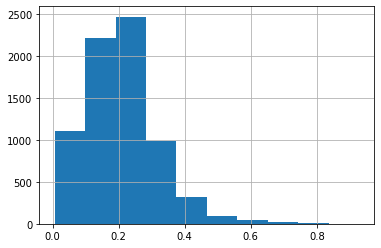

In [ ]:
pd.Series(rf_probs).hist()

In [ ]:
active['score'] = rf_probs

In [ ]:
active['score'] = 1-active['score']

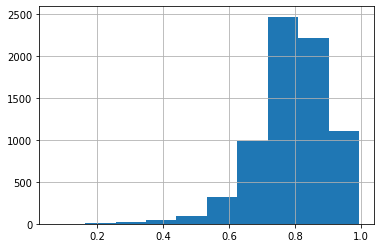

In [ ]:
active.score.hist()

In [ ]:
active[active['score'] >= 0.5].count()

index                7161
non_sawari           7161
freq_work_days       7161
FF                   7161
avg_trip_time        7161
ratings_perc         7161
promo_rides_perc     7161
physical_loc_perc    7161
bonus                7161
avg_bonus            7161
total_bonus          7161
_id                  7161
Last_date            7161
defaulter            7161
score                7161
dtype: int64

In [ ]:
from datetime import date
today = date.today()

from google.colab import files
active.to_csv('Driverprofile {}.csv'.format(today),index=True, header=True)
import time

time.sleep(10)

In [ ]:
files.download('Driverprofile {}.csv'.format(today))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>